# Kerasを用いた時系列データ解析

1. データの可視化
2. 周期の把握
3. パラメータの決定
4. モデルの構築
5. 予測と評価


In [1]:
import keras

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input, RepeatVector, TimeDistributed, SimpleRNN, GRU, LSTM, Activation
from keras.callbacks import EarlyStopping
from keras import metrics

import pandas as pd
import numpy as np


%matplotlib inline
import matplotlib.pyplot as plt


## データ

'https://www.analyticsvidhya.com/wp-content/uploads/2016/02' 
のデータを使用する．R言語で組み込みデータセットとして提供されている、飛行機の乗客数のデータである．

In [2]:
df = pd.read_csv('/content/AirPassengers.csv', index_col='Month',parse_dates=True) # インデックスの指定，DataTime型で読み込み

In [3]:
df.columns=['passengers']

In [4]:
df.head()

,passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


## 1. データの可視化

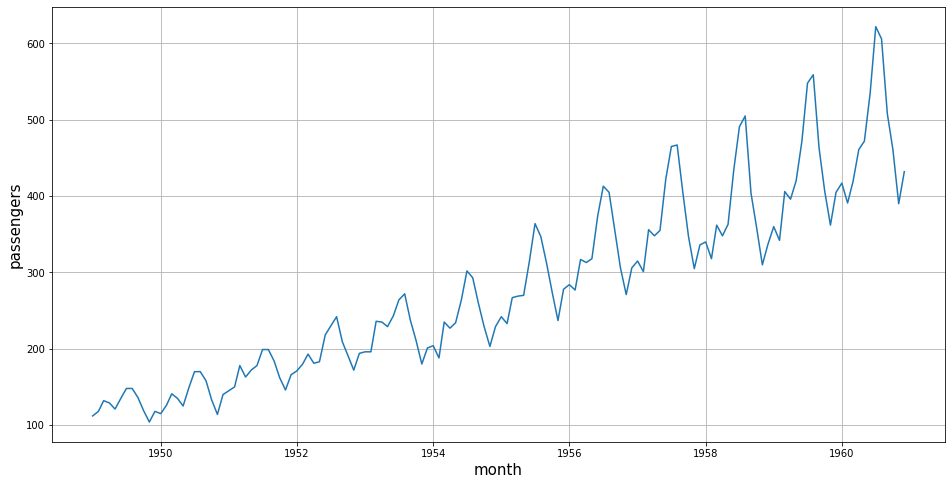

In [5]:
plt.figure(figsize=(16,8))
plt.plot(df['passengers'])

plt.xlabel('month',fontsize=15)
plt.ylabel('passengers',fontsize=15)
plt.grid()

## 2. 移動平均・周期の把握

- 移動平均
時系列データにおいて，ある一定区間ごとの平均値を区間をずらしながら求める手法．偶然誤差による変動を取り除き，滑らかなトレンドを得ることができる．平均化すればするほど個別の情報が分かりずらくなる，またはある個所で発生した突発的な変化点に気が付きにくくなるといったデメリットがある．

- 自己相関係数

異なるデータの時点間の関係性（相関）を表す指標
- 偏自己相関係数

注目している観測点以外の要因を無視した、時点間の関係性（相関）を表す指標

In [6]:
import statsmodels.api as sm
import seaborn as sns

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [7]:
# 3項平均
df_rolling = df.rolling(7).mean()
df_rolling.head()

,passengers
Month,
1949-01-01,NaN
1949-02-01,NaN
1949-03-01,NaN
1949-04-01,NaN
1949-05-01,NaN


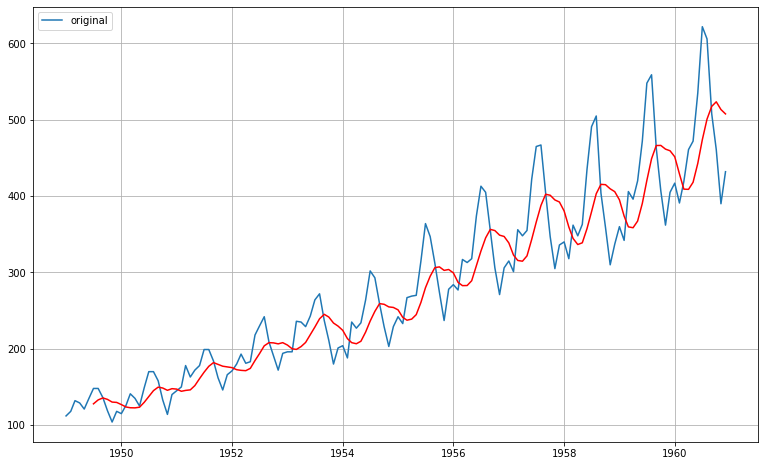

In [8]:
plt.figure(figsize=(13,8))
plt.plot(df['passengers'], label='original')
plt.plot(df_rolling['passengers'], color='red')
plt.legend()
plt.grid()

In [9]:
# オリジナル ->トレンド成分、季節成分、残差成分に分解してプロット
res = sm.tsa.seasonal_decompose(df['passengers'])

trend = res.trend
seasonal = res.seasonal
residual = res.resid

plt.figure(figsize=(16, 8))

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

Text(0, 0.5, 'Original')

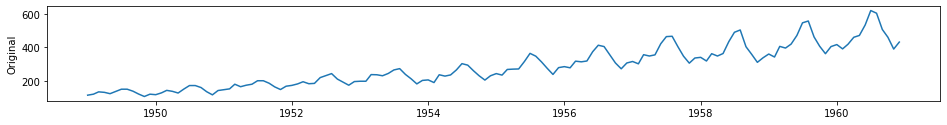

In [10]:
# オリジナルの時系列データプロット
plt.figure(figsize=(16, 8))
plt.subplot(411)
plt.plot(df['passengers'])
plt.ylabel('Original')


Text(0, 0.5, 'Trend')

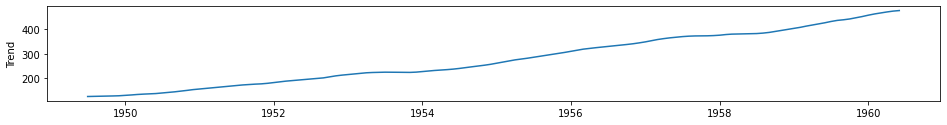

In [11]:
# trend のプロット
plt.figure(figsize=(16, 8))
plt.subplot(412)
plt.plot(trend)
plt.ylabel('Trend')

Text(0, 0.5, 'Seasonality')

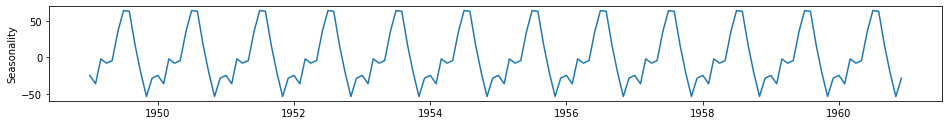

In [12]:
# seasonal のプロット
plt.figure(figsize=(16, 8))
plt.subplot(413)
plt.plot(seasonal)
plt.ylabel('Seasonality')


Text(0, 0.5, 'Residuals')

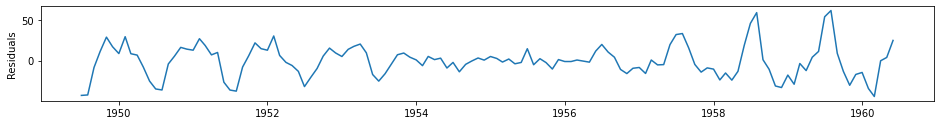

In [13]:
# residual のプロット
plt.figure(figsize=(16, 8))
plt.subplot(414)
plt.plot(residual)
plt.ylabel('Residuals')


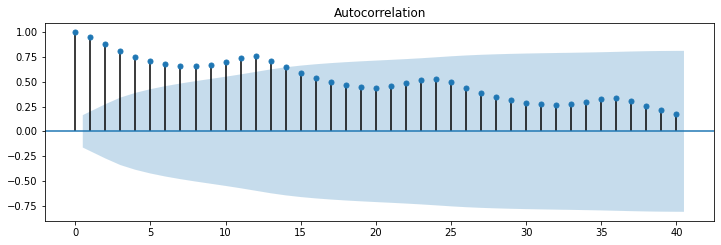

In [14]:
# 自己相関
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df.passengers, lags=40, ax=ax1)

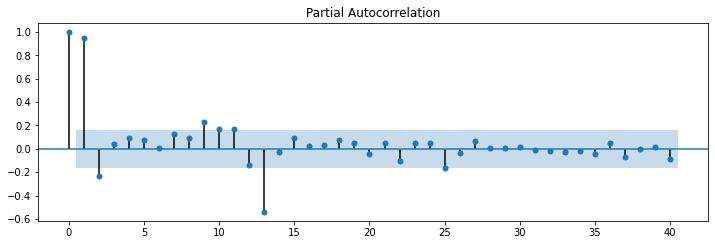

In [15]:
# 偏自己相関のグラフ
fig = plt.figure(figsize=(12,8))
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df.passengers, lags=40, ax=ax2,method='ywmle')


In [16]:
# 階差系列データの作成
diff = df.passengers - df.passengers.shift()
diff = diff.dropna()

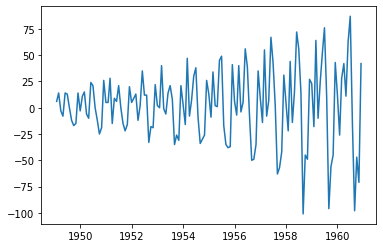

In [17]:
# 階差系列のグラフ
ax2 = fig.add_subplot(122)
plt.plot(diff)

In [18]:
diff.head()

Month
1949-02-01     6.0
1949-03-01    14.0
1949-04-01    -3.0
1949-05-01    -8.0
1949-06-01    14.0
Name: passengers, dtype: float64

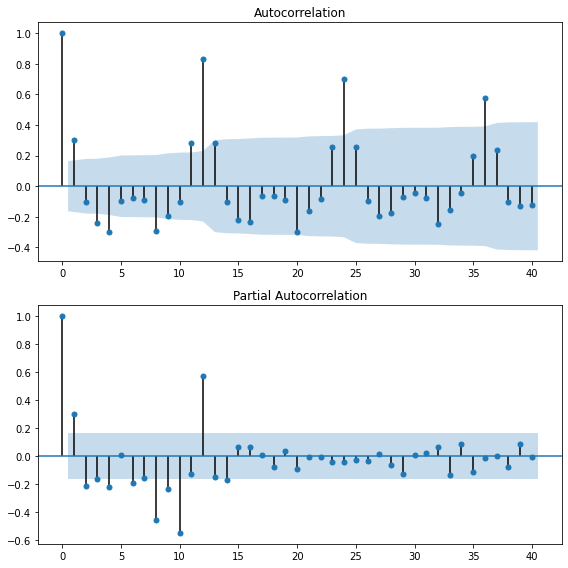

In [19]:
# 階差系列データでコレログラム作成
fig = plt.figure(figsize=(8, 8))

# 自己相関(ACF)のグラフ
ax1 = fig.add_subplot(211)
sm.graphics.tsa.plot_acf(diff, lags=40, ax=ax1) #ACF計算とグラフ自動作成

# 偏自己相関(PACF)のグラフ
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(diff, lags=40, ax=ax2, method='ywmle') #PACF計算とグラフ自動作成

plt.tight_layout() # グラフ間スキマ調整

## モデルの構築

学習用データxと、正解データyを用意する．10年分くらいのデータがあるため，その一部を学習用に使う．2年間のデータ(24データ)を用いて，次に一年(12データ)を予測するように学習する．



### データの前処理
正規化

In [2]:
df = pd.read_csv('AirPassengers.csv', index_col='Month', dtype={1: 'float'})

In [3]:
from sklearn.preprocessing import MinMaxScaler

In [4]:
# Scale the data 
sc=MinMaxScaler(feature_range=(0,1))
df['passengers'] = sc.fit_transform(df)
df.drop('#Passengers', axis=1, inplace=True)

df.head()

,passengers
Month,
1949-01,0.015444
1949-02,0.027027
1949-03,0.054054
1949-04,0.048263
1949-05,0.032819


In [5]:
ts = df['passengers']

In [6]:
x = [] # train
y = [] # test (answer)
for i in range(0, 72):
    tmpX = []
    for j in range(0, 24):
        tmpX.append(ts[i+j])
    x.append(tmpX)
    
    tmpY = []
    for j in range(0, 12):
        tmpY.append(ts[24+i+j])
    y.append(tmpY)

In [7]:
x = np.array(x)
y = np.array(y)
x = x.reshape((x.shape[0], x.shape[1], 1))
y = y.reshape((y.shape[0], y.shape[1], 1))

## LSTMモデル

1. Sequentialは，あるレイヤの全ノードと次レイヤの全ノードをつなぐDNNのモデルである．
2. DNNの1層目として，LSTMを追加する．引数は，出力の次元数，活性化関数．入力データのフォーマットである．
3. RepeatVectorにより，入力を繰り返す．ここでの繰り返し回数は，予測範囲(ステップ)となる．今回は12データ．
4. LSTMを再度追加する．ここでは，return_sequence=True とする．
5. TimeDistributed を指定し，Dense(1) とすることで出力の次元数
6. コンパイルして，学習時の最適化関数，損失関数を指定する．

In [8]:
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(24, 1))) # 入力データ数が24
model.add(RepeatVector(12)) # 予測範囲は12ステップなので、RepeatVectoorに12を指定する必要がある．
model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(1)))

In [96]:
'''  
model = Sequential([
  LSTM(100, return_sequences=True, input_shape=(24, 1)),
  RepeatVector(12),
  LSTM(100, return_sequences=True),
  LSTM(100, return_sequences=True),
  TimeDistributed(Dense(1))
])
 '''

'  \nmodel = Sequential([\n  LSTM(100, return_sequences=True, input_shape=(24, 1)),\n  RepeatVector(12),\n  LSTM(100, return_sequences=True),\n  LSTM(100, return_sequences=True),\n  TimeDistributed(Dense(1))\n])\n '

In [9]:
model.compile(optimizer='adam', loss='mse', metrics=['mean_squared_error'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 repeat_vector (RepeatVector  (None, 12, 50)           0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 12, 50)            20200     
                                                                 
 lstm_2 (LSTM)               (None, 12, 50)            20200     
                                                                 
 time_distributed (TimeDistr  (None, 12, 1)            51        
 ibuted)                                                         
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-traina

In [10]:
es = EarlyStopping(monitor='val_loss',
                   patience=10,
                   verbose=1)

In [11]:
history = model.fit(x,
                    y,
                    epochs=500,
                    batch_size=32,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[es]
                    )

Epoch 1/500
2/2 [==============================] - 5s 565ms/step - loss: 0.0806 - mean_squared_error: 0.0806 - val_loss: 0.2162 - val_mean_squared_error: 0.2162
Epoch 2/500
2/2 [==============================] - 0s 45ms/step - loss: 0.0719 - mean_squared_error: 0.0719 - val_loss: 0.1963 - val_mean_squared_error: 0.1963
Epoch 3/500
2/2 [==============================] - 0s 44ms/step - loss: 0.0629 - mean_squared_error: 0.0629 - val_loss: 0.1736 - val_mean_squared_error: 0.1736
Epoch 4/500
2/2 [==============================] - 0s 51ms/step - loss: 0.0530 - mean_squared_error: 0.0530 - val_loss: 0.1476 - val_mean_squared_error: 0.1476
Epoch 5/500
2/2 [==============================] - 0s 46ms/step - loss: 0.0421 - mean_squared_error: 0.0421 - val_loss: 0.1181 - val_mean_squared_error: 0.1181
Epoch 6/500
2/2 [==============================] - 0s 49ms/step - loss: 0.0317 - mean_squared_error: 0.0317 - val_loss: 0.0863 - val_mean_squared_error: 0.0863
Epoch 7/500
2/2 [======================

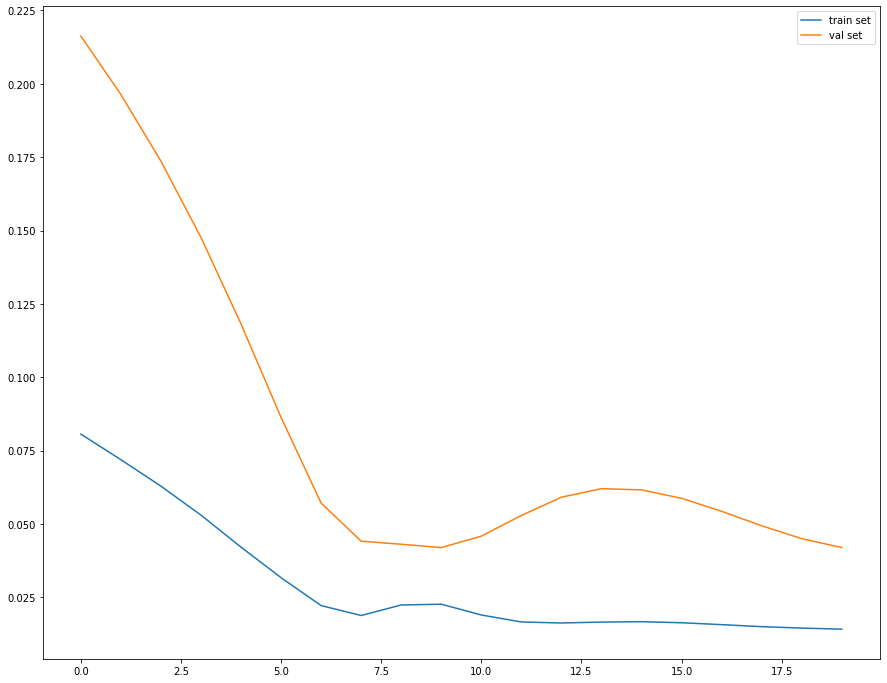

In [13]:
plt.figure(figsize=(15, 12))
plt.plot(history.history['loss'], label='train set')
plt.plot(history.history['val_loss'], label='val set')
plt.legend()
plt.show()

### 予測，評価

In [100]:
df_real = pd.read_csv('AirPassengers.csv', index_col='Month', dtype={1: 'float'})

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


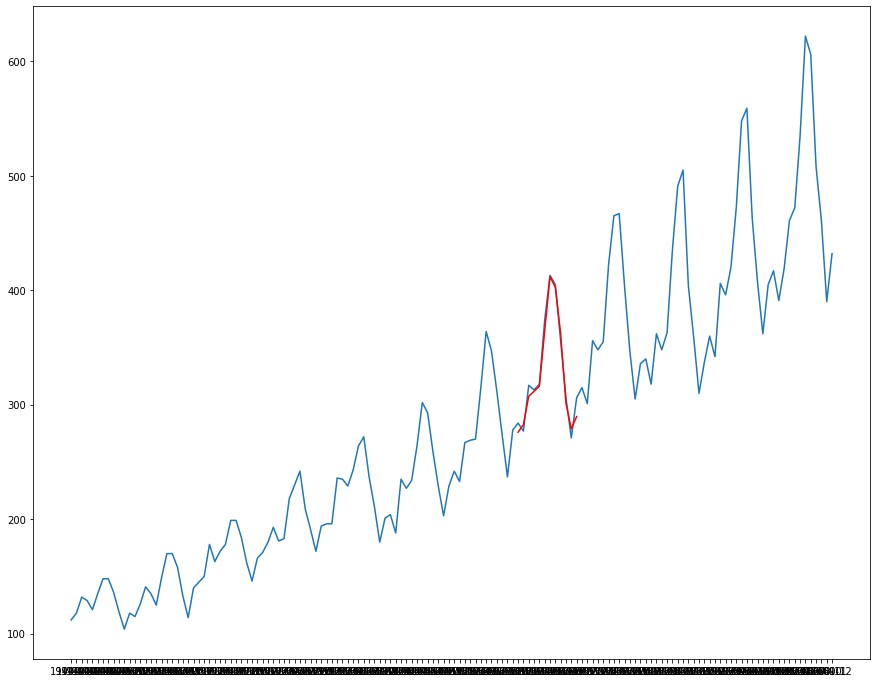

In [103]:
# データ60番～83番から、次の一年(84番～95番)を予測
input = np.array(ts[60:84]) 
input = input.reshape((1,24,1))
yhat = model.predict(input)
 
# 可視化用に、予測結果yhatを、配列predictに格納
predict = []
for i in range(0, 12):
    predict.append(yhat[0][i])

# 正規化をもどす
pred_unsc =  sc.inverse_transform(predict)

# 比較するために実データをプロット
plt.figure(figsize=(15, 12))
plt.plot(df_real['#Passengers'])
 
# 予測したデータをプロット
xdata = np.arange(84, 96, 1)
plt.plot(xdata, pred_unsc, 'r')

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


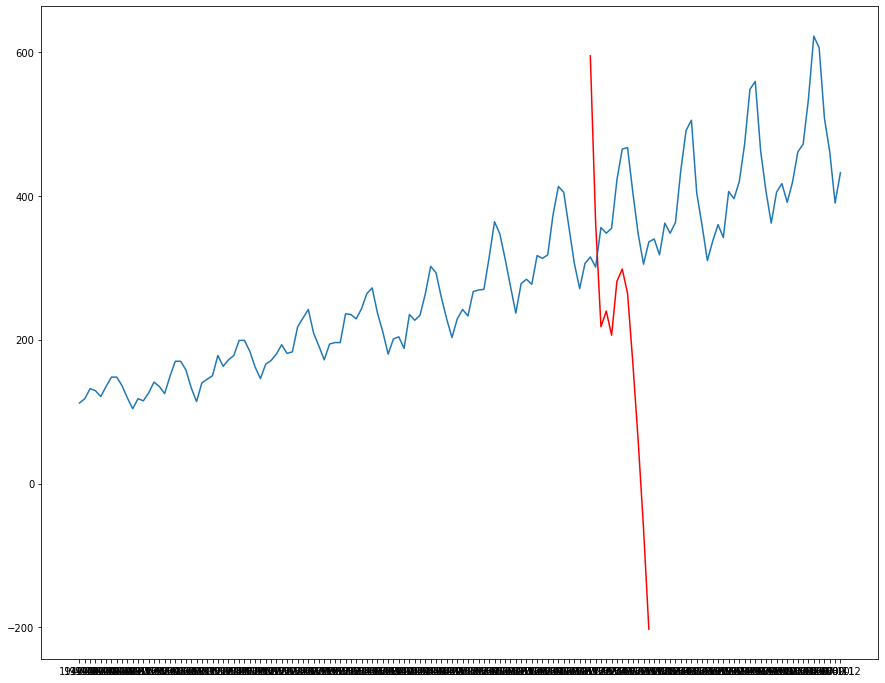

In [106]:
input = np.array(ts[72:96])
input = input.reshape((1,24,1))
yhat = model.predict(input)
 
predict = []
for i in range(0, 12):
    predict.append(yhat[0][i])

pred_unsc =  sc.inverse_transform(predict)

plt.figure(figsize=(15, 12))
plt.plot(df_real['#Passengers'])
xdata = np.arange(96, 108, 1)
plt.plot(xdata, pred_unsc, 'r')

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


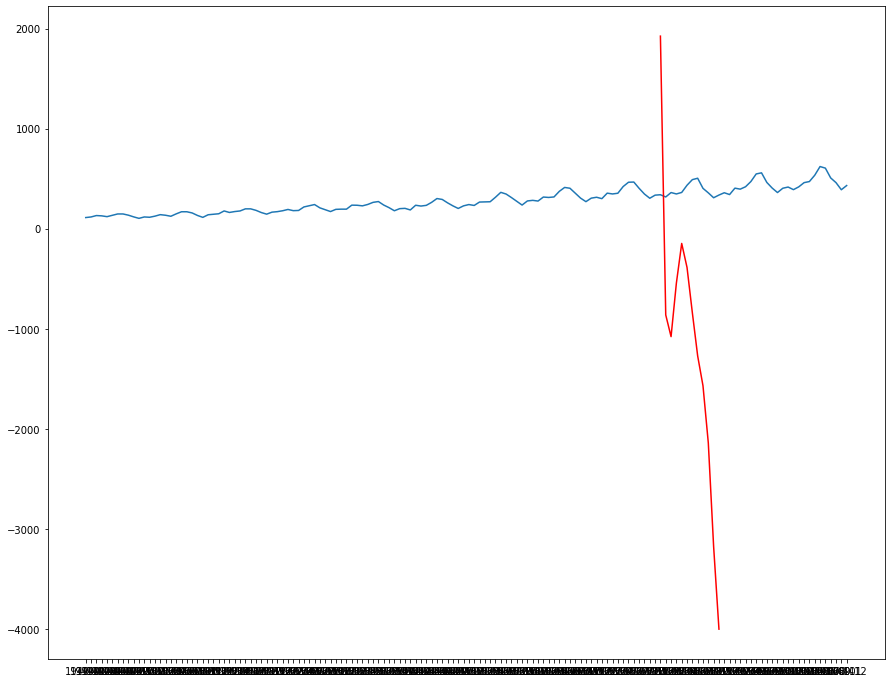

In [107]:
input = np.array(ts[84:108])
input = input.reshape((1,24,1))
yhat = model.predict(input)
 
predict = []
for i in range(0, 12):
    predict.append(yhat[0][i])

pred_unsc =  sc.inverse_transform(predict)

plt.figure(figsize=(15, 12)) 
plt.plot(df_real['#Passengers'])
xdata = np.arange(108, 120, 1)
plt.plot(xdata, pred_unsc, 'r')

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


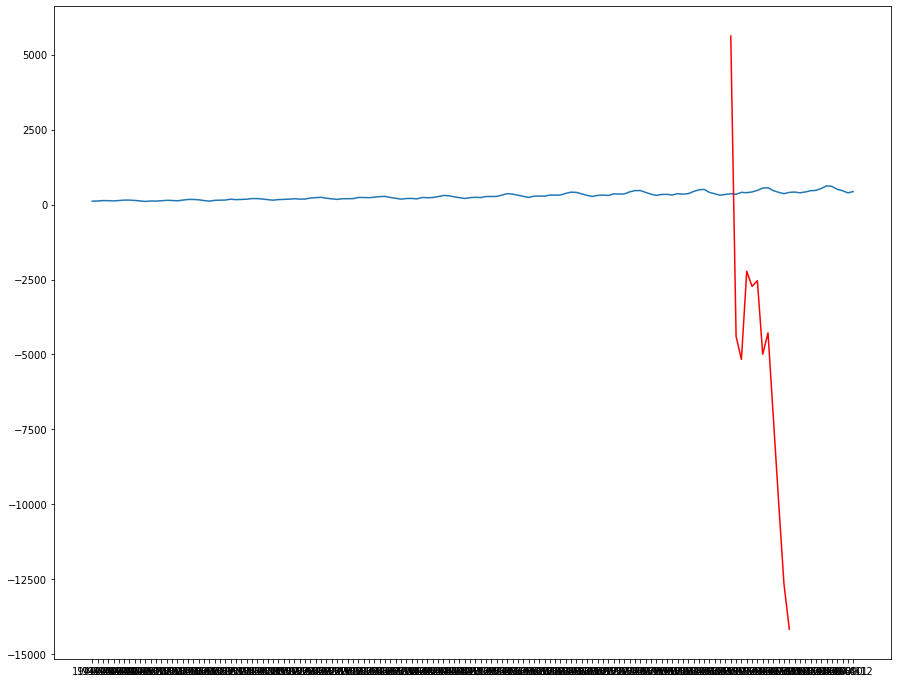

In [109]:
input = np.array(ts[96:120])
input = input.reshape((1,24,1))
yhat = model.predict(input)
 
predict = []
for i in range(0, 12):
    predict.append(yhat[0][i])

pred_unsc =  sc.inverse_transform(predict)

plt.figure(figsize=(15, 12)) 
plt.plot(df_real['#Passengers'])
xdata = np.arange(120, 132, 1)
plt.plot(xdata, pred_unsc, 'r')

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


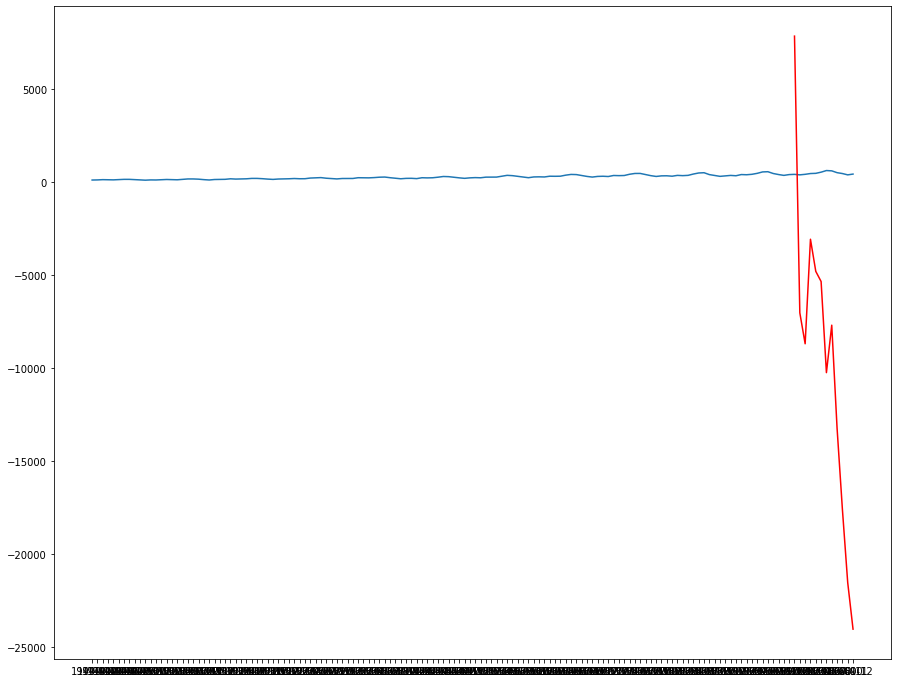

In [110]:
input = np.array(ts[108:132])
input = input.reshape((1,24,1))
yhat = model.predict(input)
 
predict = []
for i in range(0, 12):
    predict.append(yhat[0][i])
 
pred_unsc =  sc.inverse_transform(predict)

plt.figure(figsize=(15, 12)) 
plt.plot(df_real['#Passengers'])
xdata = np.arange(132, 144, 1)
plt.plot(xdata, pred_unsc, 'r')